In [1]:
import numpy
from matplotlib import pyplot as plt
from frc3223_azurite.motors import *
from frc3223_azurite.conversions import *
from frc3223_azurite.pidcontroller import NoThreadingPIDController as PIDController
from arm import ArmSimulation

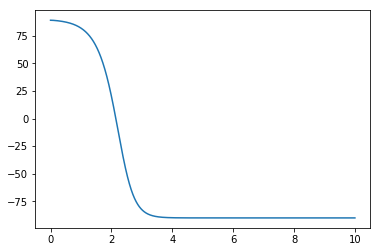

In [102]:
def init(state):
    state.voltage_p = 0
    #state.pid = PIDController(Kp = 0.0, Ki = 0.0, Kd = 0.0, Kf = 0.0, source = state.pid_source, output = state.pid_output)
    #state.pid.setOutputRange(-1, 1)
    #state.pid.setSetpoint(numpy.radians(45))
    #state.pid.enable()
    
def periodic(state):
    #state.voltage_p = 0.0
    pass

sim = ArmSimulation(
    dt_s=0.001,
    starting_position_rad=numpy.radians(89),
    end_mass_kg=lbs_to_kg(0.65),
    arm_mass_kg=lbs_to_kg(2.0),
    arm_length_m=inch_to_meter(15),
    pid_sample_rate_s=0.050,
    nominal_voltage=12.,
    damping=0.01,
    periodic = periodic,
    init = init,
    motor_system=MotorSystem(motor=am9015, motor_count=1, gearing_ratio=64),
)
sim.run_sim(timeout=10.)

#plt.ylim(43, 48)
thetas_deg = numpy.degrees(sim.thetas)
plt.plot(sim.ts, thetas_deg, )
plt.show()

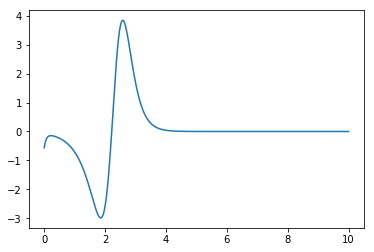

In [106]:
n = 1
plt.plot(sim.ts[0:len(sim.ts)//n], sim.a_s[0:len(sim.voltages)//n])
plt.show()

In [92]:
from matplotlib import animation, rc
from IPython.display import HTML
import matplotlib
# uncomment when running on ubuntu
#matplotlib.rcParams['animation.writer'] = 'avconv'
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
beta = numpy.zeros(shape=(2,))
radii = numpy.linspace(0, 1, 2)
line, = ax.plot(beta, radii)
dt = sim.ts[1]-sim.ts[0]
n = int(0.04 / dt)
L = len(sim.ts) // n - 1

def init():
    return (line,)
def animate(i): 
    theta = sim.thetas[i * n]
    beta[:] = theta
    line.set_data(beta, radii)
    return (line,)
    

anim = animation.FuncAnimation(fig, animate, frames=L, interval=20, blit=True)
HTML(anim.to_html5_video())